In [1]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from pandas import get_dummies
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [54]:
import pandas as pd
import numpy as np

In [3]:
%matplotlib inline

In [57]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[0:10000], data[10000:14980]
    # reshaping the data for restructuring
	train = array(train).reshape(train.shape[0],train.shape[1])
	test = array(test).reshape(test.shape[0],test.shape[1])
	# restructure into windows of weekly data
	train = array(split(train, len(train)/10))
	test = array(split(test, len(test)/10))
	print('The shape of train is: ',train.shape, 'The data structure is: [samples,timesteps, features]') 
	print('The shape of test is: ',test.shape, 'The data structure is: [samples,timesteps, features]')
	return train, test

In [6]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [7]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	print(actual.shape)
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [8]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [36]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=10):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

##### ED-LSTM Model

In [73]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 3, 128
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# define checkpoint
	checkpointer = ModelCheckpoint(filepath="ed_lstm_m10.hdf5", verbose=1, save_best_only=False)
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpointer])
	return model

##### LSTM Model

In [70]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 1, 32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# define checkpoint
	checkpointer = ModelCheckpoint(filepath="lstm_10step.hdf5", verbose=1, save_best_only=False)
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[checkpointer])
	return model

##### CNN-LSTM Model

In [400]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 3, 128
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [11]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [12]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
    
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) # index number of imbalance in test set is imp
	return score, scores, predictions

In [76]:
# load the new data file
dataset = read_csv('batch2.csv')

##### Consolidate Dataset

In [77]:
X_Full = dataset[['c','s1', 's2', 's3', 's4', 's5', 's6', 's7','s8','s9','s10','s11', 's12', 's13',
                  's14', 's15', 's16', 's17','s18','s19','s20']]

In [63]:
X_Full = dataset[['c','h1','h2','h3','h4','h5','h6','h7','h8','h9','h10','h11','h12','h13','h14',
                     'h15','h16','h17','h18','h19']]

In [78]:
X_Full.head()

c        s1        s2        s3        s4        s5        s6  \
0 -0.252981 -0.258513 -0.271136 -0.265905 -0.236656 -0.264391 -0.245431   
1 -0.252484 -0.259912 -0.272623 -0.266794 -0.237998 -0.266155 -0.246028   
2 -0.254035 -0.259525 -0.272312 -0.266402 -0.237671 -0.265789 -0.245647   
3 -0.253619 -0.259061 -0.271956 -0.265938 -0.237285 -0.265335 -0.245197   
4 -0.254556 -0.258102 -0.271115 -0.265039 -0.236444 -0.264395 -0.244345   

         s7        s8        s9  ...       s11       s12       s13       s14  \
0 -0.238485 -0.247537 -0.237131  ... -0.251595 -0.233542 -0.221914 -0.220517   
1 -0.238808 -0.248675 -0.238103  ... -0.252503 -0.234532 -0.222328 -0.221921   
2 -0.238408 -0.248315 -0.237770  ... -0.252080 -0.234242 -0.222011 -0.221680   
3 -0.237948 -0.247877 -0.237376  ... -0.251558 -0.233901 -0.221645 -0.221391   
4 -0.237080 -0.247022 -0.236584  ... -0.250641 -0.233183 -0.220946 -0.220732   

        s15       s16       s17       s18       s19       s20  
0 -0.222250 -0.231067 -0.222280 -0.225001 -0.216152 -0.221579  
1 -0.223803 -0.231887 -0.223245 -0.225594 -0.217372 -0.222200  
2 -0.223517 -0.231547 -0.222899 -0.225251 -0.217080 -0.221823  
3 -0.223158 -0.231132 -0.222472 -0.224831 -0.216713 -0.221357  
4 -0.222420 -0.230376 -0.221692 -0.224093 -0.215999 -0.220567  

[5 rows x 21 columns]

In [18]:
train, test = X_Full[0:200], X_Full[-220:-20]

In [19]:
train.shape

(200, 21)

##### Split Data

In [79]:
# split into train and test
train, test = split_dataset(X_Full.values)

The shape of train is:  (1000, 10, 21) The data structure is: [samples,timesteps, features]
The shape of test is:  (498, 10, 21) The data structure is: [samples,timesteps, features]


##### Evaluate Model and Get Scores

In [80]:
# evaluate model and get scores
n_input = 10
score_ED_LSTM, scores_ED_LSTM, predictions = evaluate_model(train, test, n_input)


Epoch 00001: saving model to ed_lstm_m10.hdf5

Epoch 00002: saving model to ed_lstm_m10.hdf5

Epoch 00003: saving model to ed_lstm_m10.hdf5
(498, 10)


In [71]:
# evaluate model and get scores
n_input = 60
score_lstm, scores_LSTM, predictions = evaluate_model(train, test, n_input)


Epoch 00001: saving model to lstm_10step.hdf5
(498, 10)


In [401]:
# evaluate model and get scores
n_input = 60
score_CNN_LSTM, scores_CNN_LSTM, predictions = evaluate_model(train, test, n_input)

(250, 20)


LSTM: [0.186] 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2
ED_LSTM: [0.180] 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2


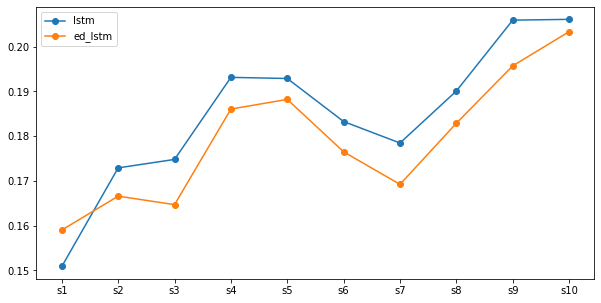

In [81]:
# summarize scores
summarize_scores('LSTM', score_lstm, scores_LSTM)
summarize_scores('ED_LSTM', score_ED_LSTM, scores_ED_LSTM)
#summarize_scores('CNN_LSTM', score_CNN_LSTM, scores_CNN_LSTM)
# plot scores
days = ['s1', 's2', 's3', 's4', 's5', 's6', 's7','s8','s9','s10']
pyplot.figure(figsize=(10,5))
pyplot.plot(days, scores_LSTM, marker='o', label='lstm')
pyplot.plot(days, scores_ED_LSTM, marker='o', label='ed_lstm')
#pyplot.plot(days, scores_CNN_LSTM, marker='o', label='cnn_lstm')
pyplot.legend()
pyplot.show()

In [46]:
predictions.shape

(498, 10)

In [32]:
predictions.shape

(498, 20)

In [33]:
predictions[30]

array([0.4037294 , 0.3851189 , 0.3978224 , 0.4076773 , 0.39894116,
       0.40849718, 0.43487802, 0.4083364 , 0.40038693, 0.3883745 ,
       0.3946444 , 0.3930697 , 0.38908395, 0.38794538, 0.38878614,
       0.37367362, 0.37965137, 0.40920228, 0.38261643, 0.38501367],
      dtype=float32)

In [414]:
test[:, :, 0]

array([[-0.99022261, -0.98990036, -0.99034906, ..., -0.91657754,
        -0.92514288, -0.92259498],
       [-0.92704761, -0.92929598, -0.92982907, ..., -0.02976659,
        -0.0290642 , -0.02817442],
       [-0.02566184, -0.02501604, -0.99983314, ...,  0.91836221,
         0.91603117,  0.76788062],
       ...,
       [-0.27436363, -0.27430202, -0.27437596, ..., -0.27236431,
        -0.2739747 , -0.27390053],
       [-0.27398706, -0.27407382, -0.27463805, ..., -0.27767942,
        -0.27550812, -0.27548645],
       [-0.27618044, -0.27608197, -0.27619274, ..., -0.27878356,
        -0.2792285 , -0.27901134]])

In [41]:
predictionDF = pd.DataFrame(data=predictions, columns=['s1', 's2', 's3', 's4', 's5', 's6', 's7',
                                                       's8','s9','s10'])

In [42]:
predictionDF.describe()

s1          s2          s3          s4          s5          s6  \
count  498.000000  498.000000  498.000000  498.000000  498.000000  498.000000   
mean     0.167140    0.167010    0.160901    0.160629    0.159945    0.163927   
std      0.313146    0.308069    0.300967    0.295163    0.292855    0.279406   
min     -0.788428   -0.762405   -0.768407   -0.732424   -0.731505   -0.684615   
25%      0.040457    0.047967    0.041760    0.041620    0.039381    0.041794   
50%      0.203541    0.196344    0.198640    0.201104    0.201719    0.210028   
75%      0.372689    0.370069    0.358424    0.361478    0.357067    0.356279   
max      0.828885    0.815979    0.791575    0.757175    0.771088    0.711270   

               s7          s8          s9         s10  
count  498.000000  498.000000  498.000000  498.000000  
mean     0.158208    0.151810    0.160663    0.156776  
std      0.269570    0.259341    0.256419    0.252670  
min     -0.677755   -0.586196   -0.603950   -0.558838  
25%      0.045109    0.026075    0.056828    0.045554  
50%      0.202287    0.190526    0.199200    0.200626  
75%      0.345155    0.337997    0.338121    0.332986  
max      0.697724    0.653884    0.676417    0.662119

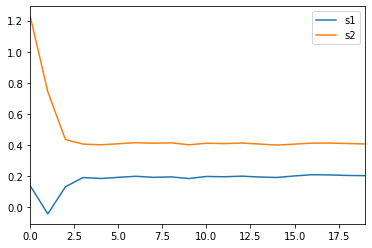

In [468]:
predictionDF[['s1','s2']].plot()

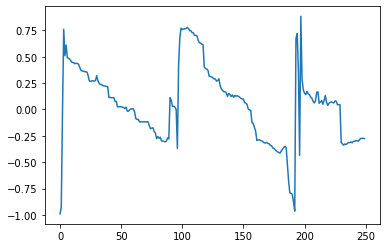

In [469]:
pyplot.plot(test[:, 0, 0]);

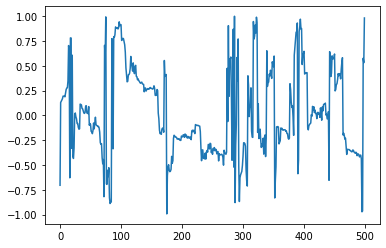

In [442]:
pyplot.plot(train[:, 19, 0]);